# Eindhoven University of Technology, Netherlands.
## Mathematics & Computer Science
## Data Science Master track
## Recommender Systems
Lecturer: Dr. Vlado Menkovski
- Franziska Boenisch
- Adriano Cardace 
- Camilo Montenegro Hernandez

## Variational Autoencoder


### Imports

In [ ]:
from keras.layers import Lambda, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, Conv2DTranspose, Dropout
from keras.models import Model, load_model, Sequential
from keras.datasets import mnist
from keras.datasets import fashion_mnist
import keras
from keras import backend as K
from keras.losses import mse, binary_crossentropy
import math
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Data
We will train a VAE for the MNIST data. This code loads the data, and increases the canvas size to 32x32 by padding zeros. This makes it easier to design convolutional autoencoder architectures with striding or pooling/upsampling.

In [ ]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalise
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# change shape: (n, 28, 28) -> (n, 28, 28, 1)
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

# pad zeros to obtain canvas size of 32x32, i.e. shape is now (n, 32, 32, 1)
x_train = np.pad(x_train, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)
x_test = np.pad(x_test, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

# get height, width, and depth values
height, width, depth = x_train.shape[1:]

## Task 1.1: Encoder architecture
**(a)** *Choose and implement a suitable architecture for the encoder. The encoder should have two outputs, which we will interpret as the mean and log variance of the approximate posterior distribution $q(z|x)$ (a Gaussian, as defined in the theoretical assignment). In this task, use a latent space dimension of 2 such that we can easily plot the latent space.*

In [ ]:
filters = 16
latent_dim =2
image_size = x_train.shape[1]
# VAE model = encoder + decoder
# build encoder model
x_in = Input(shape=(height, width, depth), name='encoder_input')
x = x_in
# add two conv layers to reduce image to 8x8. The smaller the image it gets, the more filters we use
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters, kernel_size=3, activation='relu', strides=2, padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
# extract mean and variance from the model
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# instantiate encoder model
encoder = Model(x_in, [z_mean, z_log_var], name='encoder')
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 4096)         0           conv2d_2[0][0]                   
_____________________________________

**(b)** *Motivate your choice of architecture.*

**Answer:**

The goal of the encoder is to start at the full size image and to predict a mean and a variance for each latent dimension. For this reason, we with an input layer with size 32x32. Then we added two convolutional layers to get an activation of 8x8 (increasing as we go down the number of filters). The motivation behind using convolutional layers is that they keep spatial relations. This works well on images because they have spatial correlations between the pixels, so the model can learn about the images. At this point, we need to flatten it and apply some dense layers to reduce it to the size of latent dimensions. From the flatten layer, we take two outputs, the mean an the variance. Since we are predicting a vector for the variance, we are forcing the model to use independent features (in contrast to taking a covariance matrix). 



**(c)** *What is the reason to model the logarithm of the variance, instead of the variance (or standard deviation) itself?*

**Answer:**

The reason is that we take the logarithm of the variance has to do with positive and negative numbers. We want our network to predict positive numbers for the variance. But the network can predict both, positive and negative values. So what we do is to interpret the output as the log of the positive variable (variance). The log is still differenciable, this is why we can do it. Of cause, we need to exponentiate when needed (as in the loss function). 

## Task 1.2: Decoder architecture
**(a)** *Choose and implement a suitable architecture for the decoder. Input is a sample of latent variables, the output represents the parameters of the generative distribution $p(x|z)$, i.e. the mean of a Gaussian distribution (for continuous data) or Bernoulli distribution (for binary data).*

In [ ]:
# build decoder model: given the latent vector, returns an image 32x32
z_in = Input(shape=(latent_dim,), name='z_in')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(z_in)
x = Reshape((shape[1], shape[2], shape[3]))(x)

#add two transpose layers to upsample to 32x32 from 8x8. The bigger the image it gets, the smaller is the filter size
for i in range(2):
    x = Conv2DTranspose(filters=filters, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    filters //= 2

dec_out = Conv2DTranspose(filters=1, kernel_size=3,activation='sigmoid', padding='same',name='decoder_output')(x)

# instantiate decoder model
decoder = Model(z_in, dec_out, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_in (InputLayer)            (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              12288     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 1)         289       
Total params: 67,969
Trainable params: 67,969
Non-trainable params: 0
_________________________________________________________________


**(b)** *Motivate your choice of architecture.*

**Answer:**

The main goal of the decoder is to start from a latent representation and to reconstruct the image. We get this latent representation by sampling. The encoder gave us the mean and the variance, and this defines the distribution that we need to sample from. In our architecture, we start with an input layer that gets input in the size of the latent dimension. From here, it has to generate an image. To do so, we first used a dense layer to increase the dimension size from 2 to the size we had in the encoder part (to make it symmetrical). Then we added two convolutional layers to upsample the image from 8x8 to 32x32 to end up with the original size.

## Load previously trained encoder & decoder
The following code should not be used the first time, if you haven't trained a VAE yet. After training a VAE, you can save your encoder & decoder model. This code can then be used to load these models again, such that you won't need to retrain a new model in each new session.

Note that we only load the separate encoder & decoder model, not the entire VAE model. The reason for this is that the VAE will contain a lambda layer, and Keras can have trouble saving/loading models with lambda layers.

In [ ]:
# # NOTE: DO NOT RUN THIS CODE THE FIRST TIME! Only use this to load encoder
# #       and decoder models that you have trained before, to prevent having to
# #       train a new VAE from scratch in each new session
# from google.colab import drive
# drive.mount('/content/gdrive')

# encoder_path = "/content/gdrive/My Drive/RecSys/vae_encoder_mnist.h5"
# decoder_path = "/content/gdrive/My Drive/RecSys/vae_decoder_mnist.h5"

# encoder = load_model(encoder_path)
# decoder = load_model(decoder_path)

# encoder.summary()
# decoder.summary()

# x_in = encoder.input
# z_mean, z_log_var = encoder.output
# latent_dim = int(z_mean.shape[1])

## Task 1.3: Reparametrisation trick
*To implement sampling with the reparametrisation trick, we will define a custom lambda layer. It takes the mean and log variance of $q(z|x)$ as input, and outputs a sample from $q(z|x)$. This is done by first sampling from a standard Gaussian (Normal) distribution, and then applying the proper transformation to obtain a sample from $q(z|x)$ with the given mean and variance. Implement this transformation.*

In [ ]:
def sampling(args):
    """Reparametrisation trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of q(z|x)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch_dim = K.shape(z_mean)[0]
    z_dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch_dim, z_dim))
    #sample from a unit Gaussian, multiply by variance and add the bias (that are given by the encoder)
    #we take the exp since we are considering the log variance
    return z_mean + K.exp(z_log_var) * epsilon

# use reparametrisation trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])

In [ ]:
# instantiate full VAE model
#take output of the encoder(z) and pass it through the decoder
x_mean = decoder(z)
# the model gets as input the original image, and outputs the mean for each pixel 
vae = Model(x_in, x_mean, name='vae')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 4096)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

## Task 1.4: Loss function
*Now we define the loss function, which you have derived in the theoretical part of the assignment. Note: we wish to maximise the ELBO, but Keras formulates training objectives as a loss function to minimise, so the loss function is the negative ELBO:*
$-\mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x|z)] + KL(q_\phi(z|x) || p(z))$.

*We split this into two terms, the reconstruction loss and the KL loss.*


### Reconstruction loss
*We start with the first term: $-\mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x|z)]$.*

*We approximate the expectation with a single Monte Carlo sample (using the reparametrisation trick such that the loss function is differentiable), which we can readily obtain from the sampling layer of our encoder model (output `z`). So all you need to implement is the loss function $-\log p_\theta(x|z_{sample})$. You've derived the formula for this in the theoretical part of the assignment, for both a Bernoulli distribution (for discrete data) and a Gaussian distribution with fixed standard deviation (for continuous data). Implement both versions here. Choose a suitable standard deviation value for the Gaussian.*

### KL loss
*The second term of the loss is the KL Divergence $KL(q_\phi(z|x) || p(z))$, which as we saw has a closed form for our choice of posterior and prior (both Gaussians):
$ \frac{1}{2} \sum_{k=1}^K (m_k^2 + s_k^2 - \log s_k^2 - 1)$ (see the theoretical part of the assignment for explanation of the notations). Implement it here.*


##### Implementation notes:
* Always use functions from the Keras backend (available through `from keras import backend as K`) for Tensor operations in your loss function. This way, Keras can perform automatic differentiation to compute the gradients for training. E.g. `K.sum(), K.square(), K.exp()`. You can use operators such as `+` and `*`, they will automatically convert to Tensor operations.
* Make sure to use `K.flatten(x_in)` and `K.flatten(x_mean)` whenever you need them in your loss functions, don't use `x_in` or `x_mean`. The `(height, width, depth)` structure of the data is only needed for convolutional layers, but not in the loss function.
* Note that the formulas you derived in the theoretical assignment are for a single data point or latent variable. Keras however expects a batch of data points or latent variables, so the first dimension in a Tensor is always the batch dimension. For most operations, broadcasting will automatically make computations operate on each data point in a batch individually, but for operations such as `K.sum` you need to make sure you specify the correct axis.

In [ ]:
# reconstruction loss
gen_model = "bernoulli"  # "bernoulli" or "gaussian"

if gen_model == "bernoulli":    
#The cross entropy is defined as −(ylog(p)+(1−y)log(1−p)), that is a positive quantity. Hence in our case
# we are computing the negative cross entropy, since we are not putting the minus sign in front of the formula again.
# Both log(p) and log(1−p) are negative quantities, hence the sum is negative too. 

    reconstruction_loss = binary_crossentropy(K.flatten(x_in), K.flatten(x_mean))

elif gen_model == "gaussian":
    dec_std = 1 / math.sqrt(2)
    
    input_image = K.flatten(x_in)
    prediction = K.flatten(x_mean)
    #Here we compute the constant term we derived in theoretical part of the assignment, although it is not important for
    #the optimiziation part.
    constant = K.log(2*math.pi*dec_std**2)* image_size * image_size
    #With the inner sum we compute the squared error between predictions and the true pixels. Since this is a vector,
    #we divide each element by the std, and finally we sum up all this terms to compute the sum of the pixel losses. 
    squared_error = K.sum(K.sum(input_image, -prediction, axis=-1)**2/dec_std**2)   
    reconstruction_loss = (constant+squared_error)*0.5
    ####

#Keras returns a mean, but in our case we need the sum, this is why we multiply by the size of the image
reconstruction_loss *= image_size * image_size
# reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
# we use .add_loss instead of including a loss function in .compile, such that
#     we don't have to supply any "true labels", as training is unsupervised
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 4096)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

## Task 1.5: Training & evaluating the model
*Train the model for 50 epochs with batch size 100. Choose whether to use the Bernoulli or Gaussian generative distribution. On Google Colab, go to Edit > Notebook settings and make sure to select "GPU" as hardware accelerator.*

In [ ]:
batch_size = 100
epochs = 20

# train the autoencoder
vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 11s 178us/step - loss: 208.3377 - val_loss: 170.5085
Epoch 2/20
60000/60000 [==============================] - 5s 91us/step - loss: 163.7352 - val_loss: 158.2441
Epoch 3/20
60000/60000 [==============================] - 5s 91us/step - loss: 156.3900 - val_loss: 154.6171
Epoch 4/20
60000/60000 [==============================] - 5s 91us/step - loss: 153.2902 - val_loss: 152.1593
Epoch 5/20
60000/60000 [==============================] - 5s 91us/step - loss: 151.5618 - val_loss: 150.7503
Epoch 6/20
60000/60000 [==============================] - 5s 92us/step - loss: 150.3775 - val_loss: 150.4688
Epoch 7/20
60000/60000 [==============================] - 5s 92us/step - loss: 149.4958 - val_loss: 149.0336
Epoch 8/20
60000/60000 [==============================] - 5s 91us/step - loss: 148.5767 - val_loss: 148.7853
Epoch 9/20
60000/60000 [====

Save the trained encoder and decoder for later use, so you don't have to retrain it for every new session:

In [ ]:
# from google.colab import drive
# import os
# drive.mount('/content/gdrive')

# os.makedirs('/content/gdrive/My Drive/RecSys/', exist_ok=True)
# encoder_path = "/content/gdrive/My Drive/RecSys/vae_encoder_mnist.h5"
# decoder_path = "/content/gdrive/My Drive/RecSys/vae_decoder_mnist.h5"

# encoder.save(encoder_path)
# decoder.save(decoder_path)

*Use the following functions to generate plots of the latent space (note that they only work for a 2-dimensional latent space).*

*The first plot shows the mean representations in latent space for data points from the test set. Although VAEs are unsupervised, we do have label information for the MNIST data, so we can use this give data points a different colour depending on their label.*

*The second plot takes linearly spaced coordinates in latent space, decodes them into data space representations, and plots them in a grid according to the latent space coordinates. So each of the images are generated, not reconstructed from data.*

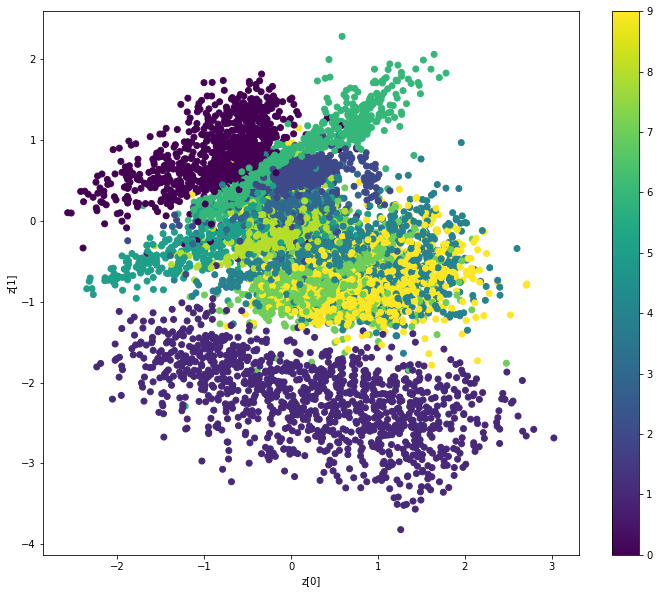

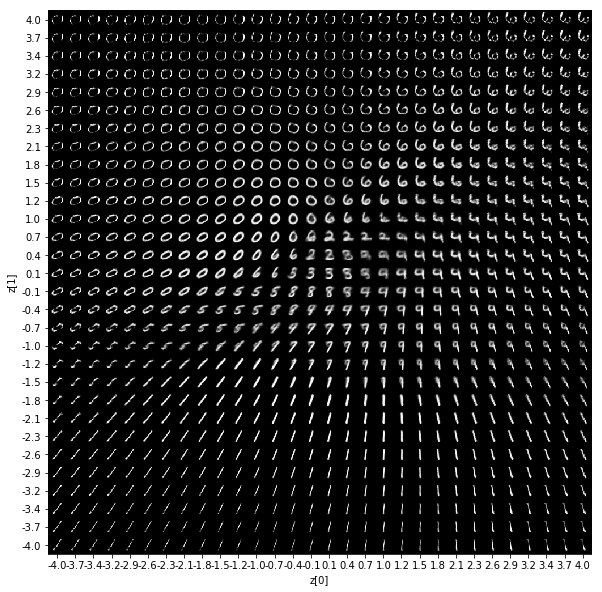

In [ ]:
batch_size = 100

def plot_results(encoder, decoder,
                 x_test, y_test,
                 batch_size=128):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        encoder (keras Model): encoder model
        decoder (keras Model): decoder model
        x_test (np.array): test data
        y_test (np.array): test labels
        batch_size (int): prediction batch size
    """

    # display a 2D plot of the digit classes in the latent space
    z_mean, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = x_test.shape[1]  # assume square images, i.e. height == width
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            x_decoded = np.reshape(x_decoded, (x_decoded.shape[0], -1))
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

# plot results
plot_results(encoder, decoder,
             x_test, y_test,
             batch_size=batch_size)

*These latent space plots can give an insight into the (latent) representations that are learned by the VAE. Evaluate what you see:*

**(a)** *Did you successfully train a generative model for this data? Motivate your answer.*



**Answer:**

Yes, we were able to successfully train a generative model. We can see from the first plot (the colorful clusters), that many digits have been clustered together (the ones are together, the zeros are together etc.) Since the goal of the VAE is to build a continious space, we also see that this is the case around the point 0,0. If we sample from a Gaussion distribution with zero mean and variance one, we will be able to obtain a meaningful output.

**(b)** *Discuss how the latent space is populated by the test data. What happens in "gaps" in the latent space? I.e. areas in latent space near the origin (so with high prior likelihood) but without any data points being mapped to them. What do images generated from such latent points look like?*

**Answer:**

In the test data, the latent space is populated continuously around the mean value (0,0), but as you go further from the mean, there are gaps and the digits are not perfectly clustered. In the gaps, we can clearly see that the digits are averaged together (for example, looking at the lower plot at coodinates (0.4,2.9) the digits 9 and seven mix up). (0.4,2.9) is exactly the spot where there is a big gap in the upper plot. 
Areas with high prior likelihood as near to the origin, have a high confusion - many digits go there. This is explicable by the fact that we are trying to reduce the KL-divergence between the distribution of each digit with a Gaussion distribution (zero mean and variance one), hence we are trying to push everything towards the point 0,0 (that's why we can say that the KL term in the loss function acts as a regulizer term).


# Question 2: FashionMNIST VAE, semi-supervised learning

In this question, we will investigate the usefulness of VAE latent representations in semi-supervised learning. Since the VAE is an unsupervised method, we don't need any labels to learn latent representations. Often, it is easy to obtain a lot of unlabelled data, but labelling this data is expensive. Thus, methods that can leverage unsupervised training to learn a supervised goal (such as classification) may be very powerful. This is the idea behind semi-supervised learning.

You will evaluate this on the FashionMNIST dataset. Although all labels are available for this dataset, we can "hide" some labels from a model, simply by not using all of them.

Besides representations learned with a VAE, you will also compare with another representation learning method: a denoising autoencoder.

## Task 2.1: Unsupervised training
**(a)** *Train two representation learning methods on the FashionMNIST dataset; a variational autoencoder (VAE) and a denoising autoencoder. Choose a suitable architecture, and encoding/latent dimension (hint: for good results a dimension of 2 will likely be too small). For fairness, use similar architectures for each of the models.*

*Use each of the models to obtain encoded representations for the full dataset (training and test set).*

### Load fashion dataset and create noisy dataset for the denoising autoencoder

In [ ]:
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# change shape: (n, 28, 28) -> (n, 28, 28, 1)
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

# pad zeros to obtain canvas size of 32x32, i.e. shape is now (n, 32, 32, 1)
x_train = np.pad(x_train, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)
x_test = np.pad(x_test, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

# get height, width, and depth values
height, width, depth = x_train.shape[1:]
#add noise to input
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

### Definition of VAE with latent_dim = 50




In [ ]:
filters = 16
latent_dim =50 

image_size = x_train.shape[1]
# VAE model = encoder + decoder
# build encoder model
x_in = Input(shape=(height, width, depth), name='encoder_input')
x = x_in
for i in range(3):
    filters *= 2
    x = Conv2D(filters=filters, kernel_size=5, activation='relu', strides=2, padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
#after 3 convolutional layers dimenions is 4x4
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

encoder = Model(x_in, [z_mean, z_log_var], name='encoder')

# build decoder model
z_in = Input(shape=(latent_dim,), name='z_in')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(z_in)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(3):
    x = Conv2DTranspose(filters=filters, kernel_size=5, activation='relu', strides=2, padding='same')(x)
    filters //= 2

dec_out = Conv2D(filters=1, kernel_size=5, activation='sigmoid', padding='same',name='decoder_output')(x)

# instantiate decoder model
decoder = Model(z_in, dec_out, name='decoder')

# use reparametrisation trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])


# instantiate full VAE model
x_mean = decoder(z)
vae = Model(x_in, x_mean, name='vae')

# reconstruction loss
reconstruction_loss = binary_crossentropy(K.flatten(x_in), K.flatten(x_mean))


#Keras returns a mean, but in our case we need the sum, this is why we multiply by the size of the image
reconstruction_loss *= image_size * image_size
# reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='Adam')

batch_size = 100
epochs = 20

# train the autoencoder
vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 17s 283us/step - loss: 286.4127 - val_loss: 249.8540
Epoch 2/20
60000/60000 [==============================] - 12s 198us/step - loss: 243.3228 - val_loss: 241.0770
Epoch 3/20
60000/60000 [==============================] - 12s 200us/step - loss: 236.6383 - val_loss: 236.2699
Epoch 4/20
60000/60000 [==============================] - 12s 198us/step - loss: 233.5525 - val_loss: 234.1750
Epoch 5/20
60000/60000 [==============================] - 12s 208us/step - loss: 231.8431 - val_loss: 233.4469
Epoch 6/20
60000/60000 [==============================] - 12s 201us/step - loss: 230.7091 - val_loss: 232.0023
Epoch 7/20
60000/60000 [==============================] - 13s 212us/step - loss: 229.8787 - val_loss: 231.1500
Epoch 8/20
60000/60000 [==============================] - 12s 206us/step - loss: 229.0375 - val_loss: 230.5891
Epoch 9/20
600

### Definition of denoising autoencoder

In [ ]:
#denoising autoencoder to be compared with vaw
input_img = Input(shape=(32, 32, 1))  # adapt this if using `channels_first` image data format
#for comparability, we also use 2 downsampling layers and two upsampling layers. The parameters are the same:
#convolution with kernel size 5 and with the same number of filters.
x = input_img
for i in range(3):
    filters *= 2
    x = Conv2D(filters=filters, kernel_size=5, activation='relu', strides=2, padding='same')(x)

shape = K.int_shape(x)
#Flatten to get the latent representation
latent = Flatten()(x)
codes = Dense(latent_dim)(latent)

z_in_DAE = Input(shape=(latent_dim,), name='z_in_DAE')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(z_in_DAE)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(3):
    x = Conv2DTranspose(filters=filters, kernel_size=5, activation='relu', strides=2, padding='same')(x)
    filters //= 2

dec_out = Conv2D(filters=1, kernel_size=5, activation='sigmoid', padding='same',name='decoder_output')(x)
#Decoder definition
DAE_decoder = Model(z_in_DAE, dec_out)

autoencoder_output =  DAE_decoder(codes)

autoencoder = Model(input_img, autoencoder_output)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 13s 223us/step - loss: 0.2953 - val_loss: 0.2376
Epoch 2/20
60000/60000 [==============================] - 13s 212us/step - loss: 0.2307 - val_loss: 0.2291
Epoch 3/20
60000/60000 [==============================] - 12s 198us/step - loss: 0.2247 - val_loss: 0.2255
Epoch 4/20
60000/60000 [==============================] - 12s 204us/step - loss: 0.2218 - val_loss: 0.2228
Epoch 5/20
60000/60000 [==============================] - 12s 198us/step - loss: 0.2199 - val_loss: 0.2216
Epoch 6/20
60000/60000 [==============================] - 12s 195us/step - loss: 0.2185 - val_loss: 0.2204
Epoch 7/20
60000/60000 [==============================] - 12s 194us/step - loss: 0.2175 - val_loss: 0.2199
Epoch 8/20
60000/60000 [==============================] - 12s 194us/step - loss: 0.2166 - val_loss: 0.2194
Epoch 9/20
60000/60000 [==============================] - 13s 221us/step - loss: 0.2158 - val_

**(b)** *Motivate your architectural choices.*

**Answer:**

The denoising autoencoder is a convolutional autoencoder. It gets an image to which noise has been added and it tries to reconstruct a non-noisy version of it. This made us choose for an architecture which consists of a symmetrical encoder and decoder. So as explained above in task 1, the encoder shrinks the representation. We are then adding a flatten and dense layer to get our latent representation. Parting from that, the decoder can restore the image.
We use sigmoid as a activation function for the last layer and binary cross-entropy as a loss function, since we are dealing with gray scale images.

## Task 2.2: Qualitative evaluation
Plotting the population of the latent space only works for a 2-dimensional latent space. For higher dimensions, we need different ways to qualitatively evaluate the models.

**(a)** *Reconstruct some images from the test set with both the VAE and DAE. Plot the reconstructions alongside the original images. Briefly discuss the results.*

**(b)** *The VAE is a generative model; generate some images with the VAE and visualise them. Also try to generate images with the DAE (even though it is not intended as a generative model) and visualise them. Discuss the results, in particular the difference between VAE and DAE.*

### Question A


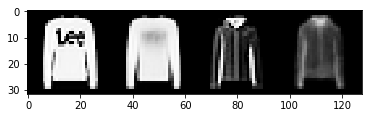

In [ ]:
original = x_test[1].reshape(32,32)
x_decoded1 = vae.predict([[x_test[1]]])
x_decoded1 = x_decoded1.reshape(32,32)
combined = np.hstack((original, x_decoded1))

original2 = x_test[6].reshape(32,32)
x_decoded2 = vae.predict([[x_test[6]]])
x_decoded2 = x_decoded2.reshape(32,32)
combined2 = np.hstack((original2, x_decoded2))

full = np.hstack((combined, combined2))
plt.imshow(full, cmap='Greys_r')
plt.show()

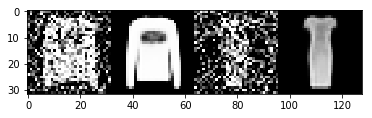

In [ ]:
original = x_test_noisy[1].reshape(32,32)
x_decoded1 = autoencoder.predict([[x_test[1]]])
x_decoded1 = x_decoded1.reshape(32,32)
combined = np.hstack((original, x_decoded1))

original2 = x_test_noisy[100].reshape(32,32)
x_decoded2 = autoencoder.predict([[x_test[100]]])
x_decoded2 = x_decoded2.reshape(32,32)
combined2 = np.hstack((original2, x_decoded2))

full = np.hstack((combined, combined2))
plt.imshow(full, cmap='Greys_r')
plt.show()

The VAE is able to generate  images that look like an image fashion MNIST, although we can see from the two samples above that they are a bit blurry. For example the brand of the t-shirt on the left is not well reconstructed. 
The DAE is able to reconstruct the original image from the noisy version. The results are satisfying in both cases.

### Question B

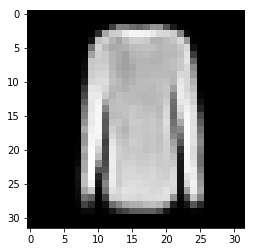

In [ ]:
#Generating images for VAE
random_latent_point = np.random.normal(0.0, 1.0, latent_dim)
random_latent_point = np.expand_dims(random_latent_point, axis=0)
gen = decoder.predict(random_latent_point)
plt.imshow(gen[0].reshape(32,32), cmap='Greys_r')
plt.show()

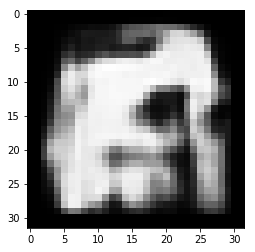

In [ ]:
#Generating images for DAE
random_latent_point = np.random.normal(0.0, 1.0, latent_dim)
random_latent_point = np.expand_dims(random_latent_point, axis=0)
gen = DAE_decoder.predict(random_latent_point)
plt.imshow(gen[0].reshape(32,32), cmap='Greys_r')
plt.show()

*Discuss the results:*


As we can see from the above examples, we are able to generate something meaningful using a VAE by samplying from a multivariate Gaussian. If we mimick this with a DAE, we see that is not able to generate images starting from noise. This behaviuour was predictable since the DAE is not a generative model, so it doesn't build a continuous latent space we can sample from. 

## Task 2.3: Semi-supervised learning
*Perform a thorough evaluation of semi-supervised learning for representations learned with your variational and denoising autoencoders.*

*Guidelines:*
* For various suitable values of $l$, randomly select $l$ instances from the training dataset, these will represent your labelled data and are the only data points that may be used for supervised learning. Make sure to include $l=60000$ (i.e. the entire dataset).
* For each value of $l$, train a few off-the-shelf methods from scikit-learn (e.g. random forest, SVM) as well as a simple multilayer perception (MLP) on representations from both the VAE and DAE, using only the $l$ available labels.
* For each value of $l$, also train an MLP on the original image data, using only the $l$ available labels.
* Visualise your results in a clear way, and report your conclusions. Was it beneficial to use unlabelled data as well as labelled data? Which representations worked best?

In [ ]:
#Definition of the two encoders to use for evaluation
latent_vae_encoder =Model(x_in,z_mean)
latent_noise_encoder = Model(input_img, codes)

#MLP with codes
def getModel(dim):
  MPL_codes = Sequential()
  MPL_codes.add(Dense(512, activation='relu', input_shape=(dim,)))
  MPL_codes.add(Dropout(0.2))
  MPL_codes.add(Dense(512, activation='relu'))
  MPL_codes.add(Dropout(0.2))
  MPL_codes.add(Dense(256, activation='relu'))
  MPL_codes.add(Dropout(0.2))
  MPL_codes.add(Dense(10, activation='softmax'))
  MPL_codes.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return MPL_codes

In [ ]:
from sklearn import svm
l_list = [50, 100, 200, 1000, 2000, 5000, 30000, 60000]
results = []

#iterate over all the sizes of the training data
for l in l_list:
  #build dataset: extract l radnom samples from full dataset
  resultsPerList = []
  names = ['No. Samples']
  indexes = np.random.choice(60000, l)
  l_train_x = x_train[indexes]
  l_train_y = y_train[indexes]

  print('start evaluation for VAE-SVM with {} samples'.format(l))
  names.append('VAE-SVM')

   #predict latent vector from original images using the VAE
  latent_representation = latent_vae_encoder.predict(l_train_x)  
  l_train_encoded = np.array(latent_representation)

  #train a SVM classifier with the encoded images
  clf = svm.SVC(gamma=0.001, C=100.)
  clf.fit(l_train_encoded, l_train_y) 
  #get encoded version for the test set 
  testx_encoded = latent_vae_encoder.predict(x_test)
  #get predictions from SVM and compare with corresponding labels 
  predictions = clf.predict(testx_encoded)
  npmean = np.mean(predictions==y_test)
  resultsPerList.append(npmean)
  print(npmean)
  
  #Train now a MLP
  print('start evaluation for VAE-MLP with {} samples'.format(l))
  names.append('VAE-MLP')
  #For MLP we need one hot encoded labels. In fashion MNIST there are 10 classes
  l_train_y_categorical = keras.utils.to_categorical(l_train_y, 10)
  l_test_y_categorical = keras.utils.to_categorical(y_test, 10)
  #get model with input size = latent dimension
  model = getModel(latent_dim)
  model.fit(l_train_encoded, l_train_y_categorical, batch_size=batch_size, epochs=epochs, verbose=0)
  score = model.evaluate(testx_encoded, l_test_y_categorical, verbose=0)
  resultsPerList.append(score[1])
  print(score[1]) 
    
  print('start evaluation for denoising autoencoder-SVM with {} samples'.format(l))
  names.append('DAE-SVM')
  #repeat same experiments but using the encoder of DAE
  latent_representation = latent_noise_encoder.predict(l_train_x)  
  print(latent_representation.shape)
  l_train_encoded = np.array(latent_representation)

  clf = svm.SVC(gamma=0.001, C=100.)
  clf.fit(l_train_encoded, l_train_y) 
  testx_encoded = latent_noise_encoder.predict(x_test)
  predictions = clf.predict(testx_encoded)
  npmean = np.mean(predictions==y_test)
  resultsPerList.append(npmean)
  print(npmean)
  
  print('start evaluation for  denoising autoencoder-MLP with {} samples'.format(l))
  names.append('DAE-MLP')
  model = getModel(testx_encoded.shape[1])
  model.fit(l_train_encoded, l_train_y_categorical, batch_size=batch_size, epochs=epochs, verbose=0)
  score = model.evaluate(testx_encoded, l_test_y_categorical, verbose=0)
  resultsPerList.append(score[1])
  print(score[1]) 
  
  print('start evaluation for MLP with original images with {} samples'.format(l))
  names.append('MLP')
  l_train_MLP = l_train_x.reshape(len(l_train_x), 32*32)
  l_test_MLP = x_test.reshape(len(x_test), 32*32)
  print(l_test_MLP.shape)
  
  #Train a MLP with original images, so input size is 32x32
  model = getModel(32*32)
  model.fit(l_train_MLP, l_train_y_categorical, batch_size=batch_size, epochs=epochs, verbose=0)
  score = model.evaluate(l_test_MLP, l_test_y_categorical, verbose=0)
  resultsPerList.append(score[1])
  print(score[1])
  
  results.append(resultsPerList)
 

start evaluation for VAE-SVM with 50 samples
0.47
start evaluation for VAE-MLP with 50 samples
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0.5174
start evaluation for denoising autoencoder-SVM with 50 samples
(50, 50)
0.5872
start evaluation for  denoising autoencoder-MLP with 50 samples
0.6195
start evaluation for MLP with original images with 50 samples
(10000, 1024)
0.5824
start evaluation for VAE-SVM with 100 samples
0.6167
start evaluation for VAE-MLP with 100 samples
0.6515
start evaluation for denoising autoencoder-SVM with 100 samples
(100, 50)
0.6722
start evaluation for  denoising autoencoder-MLP with 100 samples
0.6812
start evaluation for MLP with original images with 100 samples
(10000, 1024)
0.6244
start evaluation for VAE-SVM with 200 samples
0.6833
start evaluation for VAE-MLP with 200 samples
0.7081
start evaluation for denoising autoencoder-SVM with 200 samples
(200, 50)
0.7472
start evaluation for

In [ ]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
namesFrame = pd.DataFrame(names)
l_listFrame = pd.DataFrame(l_list).T
dataFrame = pd.DataFrame(results).T
new = pd.concat([l_listFrame,dataFrame])
new = new.reset_index(drop=True)
frame = pd.concat([namesFrame,new],axis=1)
print('Comparison Semi-supervised learning')
print(frame)

Comparison Semi-supervised learning
             0        0         1         2          3          4          5           6           7
0  No. Samples  50.0000  100.0000  200.0000  1000.0000  2000.0000  5000.0000  30000.0000  60000.0000
1      VAE-SVM   0.4700    0.6167    0.6833     0.7758     0.7884     0.7938      0.8090      0.8146
2      VAE-MLP   0.5174    0.6515    0.7081     0.8100     0.8236     0.8405      0.8666      0.8718
3      DAE-SVM   0.5872    0.6722    0.7472     0.7953     0.8237     0.8367      0.8697      0.8762
4      DAE-MLP   0.6195    0.6812    0.7445     0.8131     0.8290     0.8344      0.8698      0.8737
5          MLP   0.5824    0.6244    0.7097     0.7970     0.8152     0.8459      0.8766      0.8838


**Motivation & Conclusions:** *Explain your analysis, and draw conclusions:*

Using an autoencoder in semi-supervised learning may be useful for certain problems. Usually, when we want to train a NN for a task, we do that with labeled data. But labeled data is hard to aquire beacuse usually is obtained manually and thus expensive. Unlabeled data, however, usually exists in big quantities. The idea is now to use this unlabeled data to increase the accuracy of our NN. What we can do for it is to first train an autoencoder with unlabeled data using the NN as the encoder. Then, we use the trained autoencoder on the unlabeled data and we stack on top of it an of-the-shelf classifier such as SVM os MPL to perform classification (using the labeled data). The idea is that the autoencoder should be able to capture some interesting features of the data, and we can use this compact representation to perform classification when a small dataset is available.

What we, therefore, expect from our results is that the results of the classification obtained with the approaches that use the additional unlabeled data obtain better results than the pure MLPs on the original data with a small number of training data. This assumption is confirmed by the following paper we read (http://papers.nips.cc/paper/5352-semi-supervised-learning-with-deep-generative-models.pdf).

Looking at the results that we obtained (see table), we see that for smaller datasets (from 100 to 2000 samples) both  the VAE and DAE outperform the classifier trained on the original data, although DAE seems in general better than VAE (strangely for the dataset with 50 samples only the DAE performs better than the MLP). Hence we can conclude that training on unlabeled data was helpful. We can also notice how the difference in the accuracy between the two approaches reduces as we increase the number of labeled data on which we train the MLP. Indeed, when we use the full dataset, the classical supervised approach outperforms the semi supervised approach. This behavior was predictable.

The models are comparable in a fair way. We ensured this by using similar architectures and parameters.